In [3]:
import os 
os.chdir("..")
import numpy as np
import sympy
import cirq
import tensorflow_quantum as tfq
from tqdm import tqdm
import tensorflow as tf

from utilities.variational import VQE
from utilities.circuit_basics import Evaluator
from utilities.idinserter import IdInserter
from utilities.simplifier import Simplifier
from utilities.unitary_killer import UnitaryMurder

n_qubits = 4
qlr = 0.01
qepochs = 10**3
verbose=0
g=1
J=0
noise=0.0
problem="TFIM"
vqe_handler = VQE(n_qubits=n_qubits, lr=qlr, epochs=qepochs, patience=100,
                  random_perturbations=True, verbose=verbose, g=g, J = J, noise=noise, problem=problem)

iid = IdInserter(n_qubits=n_qubits)
Simp = Simplifier(n_qubits=n_qubits)
killer = UnitaryMurder(vqe_handler)
indexed_circuit=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]


circuit, symbols, idx_symbols = vqe_handler.give_circuit(indexed_circuit)


In [4]:
pauls = [cirq.X, cirq.Y, cirq.Z]
circuit_res = cirq.resolve_parameters(circuit, {s:0 for s,k in zip(symbols, range(len(symbols)))})
p=0.01
cbatch = []
totals=10**3
for k in range(totals):
    circ = circuit.copy()
    if k<int((1-p)*totals):
        cbatch.append(circ)
    elif int((1-p)*totals)<=k:
        which = np.random.choice(range(3), 1)[0]
        gate = pauls[which]
        for q in vqe_handler.qubits:
            circ.append(gate.on(q))
        cbatch.append(circ)

In [6]:
len(cbatch)

1000

In [7]:
circuit_input = tf.keras.Input(shape=(), dtype=tf.string)
output = tfq.layers.Expectation()(circuit_input, symbol_names=symbols, operators=tfq.convert_to_tensor([vqe_handler.observable]*1000),
        initializer=tf.keras.initializers.RandomUniform(minval=-np.pi, maxval=np.pi))

model = tf.keras.Model(inputs=circuit_input, outputs=output)
adam = tf.keras.optimizers.Adam(learning_rate=vqe_handler.lr)
model.compile(optimizer=adam, loss='mse')
tfqcircuit = tfq.convert_to_tensor(cbatch)
qoutput = tf.ones((10**3, 1))*vqe_handler.lower_bound_Eg
from datetime import datetime
now = datetime.now()
h=model.fit(x=tfqcircuit, y=qoutput, batch_size=10**3, epochs=100,
          verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=vqe_handler.patience, mode="min", min_delta=10**-3)])
print(datetime.now()-now)

Train on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 6409.8164
Epoch 2/100
1000/1000 [==============================] - 0s 237us/sample - loss: 6409.1880
Epoch 3/100
1000/1000 [==============================] - 0s 238us/sample - loss: 6408.5664
Epoch 4/100
1000/1000 [==============================] - 0s 246us/sample - loss: 6407.9355
Epoch 5/100
1000/1000 [==============================] - 0s 254us/sample - loss: 6407.2925
Epoch 6/100
1000/1000 [==============================] - 0s 247us/sample - loss: 6406.6592
Epoch 7/100
1000/1000 [==============================] - 0s 233us/sample - loss: 6406.0371
Epoch 8/100
1000/1000 [==============================] - 0s 222us/sample - loss: 6405.4048
Epoch 9/100
1000/1000 [==============================] - 0s 254us/sample - loss: 6404.7520
Epoch 10/100
1000/1000 [==============================] - 0s 255us/sample - loss: 6404.1299
Epoch 11/100
1000/1000 [==============================] - 0s 254us/sa

Epoch 90/100
1000/1000 [==============================] - 0s 215us/sample - loss: 6356.3682
Epoch 91/100
1000/1000 [==============================] - 0s 224us/sample - loss: 6355.8638
Epoch 92/100
1000/1000 [==============================] - 0s 268us/sample - loss: 6355.3711
Epoch 93/100
1000/1000 [==============================] - 0s 213us/sample - loss: 6354.8779
Epoch 94/100
1000/1000 [==============================] - 0s 233us/sample - loss: 6354.3965
Epoch 95/100
1000/1000 [==============================] - 0s 220us/sample - loss: 6353.9082
Epoch 96/100
1000/1000 [==============================] - 0s 211us/sample - loss: 6353.4199
Epoch 97/100
1000/1000 [==============================] - 0s 222us/sample - loss: 6352.9419
Epoch 98/100
1000/1000 [==============================] - 0s 238us/sample - loss: 6352.4858
Epoch 99/100
1000/1000 [==============================] - 0s 218us/sample - loss: 6352.0029
Epoch 100/100
1000/1000 [==============================] - 0s 241us/sample - los

In [3]:
import matplotlib.pyplot as plt

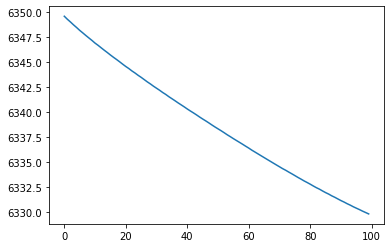

In [6]:
plt.plot(h.history["loss"])